# Farmacy Simulation with SimPy
## Scenario
A pharmacy has `NR_COUNTERS` counters with a working pharmacist each. 

The Pharmacy has `NR_MEDS` types of medicine, each having a `stock` of `MED_STOCK` units.

Customers arrive randomly using an *Exponential Distribution*.

Customers are served at the counter for a certain duration using the *Lognormal Distribution*.

While waiting in a queue, each customer has a `patience`, modelled using a *Weibull Distribution*.

Customers choose a medicine type randomly when arriving at the pharmacy.

### Math Reminder I - Exponential Distribution
The **Exponential Distribution** is the distribution of the distance between events in a **Poisson point process**, i.e. a process in which events occur continuously and independently at a constant average rate. 

The *Probability Density Function* of the **Exponential Distribution** is as follows:

$$
f(x;\lambda) = \lambda e^{-\lambda x} \quad \text{for} \quad x \geq 0
$$
and $0$ otherwise.

$\lambda$ is the *rate* parameter of our distribution. It controls *how often* an event may happen. 

In our case, if a customer arrives at a pharmacy every $t$ minutes on average, then $\lambda = 1/t$ 

### Math Reminder II - Lognormal Distribution
The **Lognormal Distribution** is the distribution of a random variable whose *logarithm* is normally distributed. Thus, if $X$ is a normally distributed r.v., then $Y = e^X$ has a lognormal distribution.

The *Probability Density Function* of the **Lognormal Distribution** is as follows:
$$
f(x;\mu, \sigma) = \frac{1}{x\sigma \sqrt{2\pi}} \exp{(-\frac{(\ln x - \mu)^2}{2\sigma^2})}
$$

> ⚠️ **Caution:** A very important thing to know is that $\mu$ and $\sigma$ are **NOT** the mean and std of the service time we want to model. These are the mean and standard deviation of the *logarithm* of service time.

### Math Reminder III - Weibull Distribution
The **Weibull Distribution** can model a broad range of random variables. It is often used to model time to failure (of a machine, for example), time between events, or the time a person spends on a website. I chose to use it to model a customer's patience while standing in the pharmacy's queue.

The *Probability Density Function* of the **Weibull Distribution** is as follows:
$$
f(x; \lambda, k) = \frac{k}{\lambda}* (\frac{x}{\lambda})^{k-1} * e^{-(x/\lambda)^k} \quad \text{for} \quad x \geq 0
$$
and $0$ otherwise.

The two parameters, $k$ and $\lambda$, are **always** greater than $0$.

- $k$ is the **shape** parameter. It controls the *qualitative* behavior of the distribution.
- $\lambda$ is the **scale** parameter. It changes the *horizontal stretch* of the distribution. Greater $\lambda$ will stretch the curve to the right, while a lesser value will compress the pdf.

When $k < 1$:</br>
The curve becomes very steep near 0 and decays quickly. </br>
In our example, this would mean customers will lose patience almost immediately.

When $k = 1$:</br>
The **Weibull** Distribution becomes an **Exponential** Distribution.

When $k > 1$:</br>
The curve rises, peaks, then falls. The bigger the $k$, the sharper the rise and the more peaked the pdf is.



In [212]:
import random
import simpy
import numpy as np
import matplotlib.pyplot as plt
from math import log
from typing import Dict, List, Optional, NamedTuple

In [213]:
SEED = 42
LAMBDA_EXP = 1.5        # customer arrival rate for exponential distribution
MU_LOGNORM = 0.55        # mean for lognormal distribution
SIGMA_LOGNORM = 0.35     # std for lognormal distribution
SHAPE_WEIBULL = 6         # shape param for Weibull distribution
SCALE_WEIBULL = 6     # scale param for Weibull distribution
MED_STOCK = 25          # number of boxes per medicine
NR_COUNTERS = 3         # number of pharmacy cashiers / counters
NR_MED_TYPES = 3        # number of medicine types

SIM_HOURS = 1          # simulation time in hours
SIM_TIME = SIM_HOURS * 60      # total simulation time in minutes

In [214]:
n_random_vars = 4 # time between arrivals, service time, patience and medicine choice
seed_sequence = np.random.SeedSequence(SEED)
seeds = seed_sequence.spawn(n_random_vars)
print(seed_sequence)
print(seeds)

arrival_rng = np.random.default_rng(seeds[0])
service_rng = np.random.default_rng(seeds[1])
patience_rng = np.random.default_rng(seeds[2])
choice_rng = np.random.default_rng(seeds[3])


SeedSequence(
    entropy=42,
    n_children_spawned=4,
)
[SeedSequence(
    entropy=42,
    spawn_key=(0,),
), SeedSequence(
    entropy=42,
    spawn_key=(1,),
), SeedSequence(
    entropy=42,
    spawn_key=(2,),
), SeedSequence(
    entropy=42,
    spawn_key=(3,),
)]


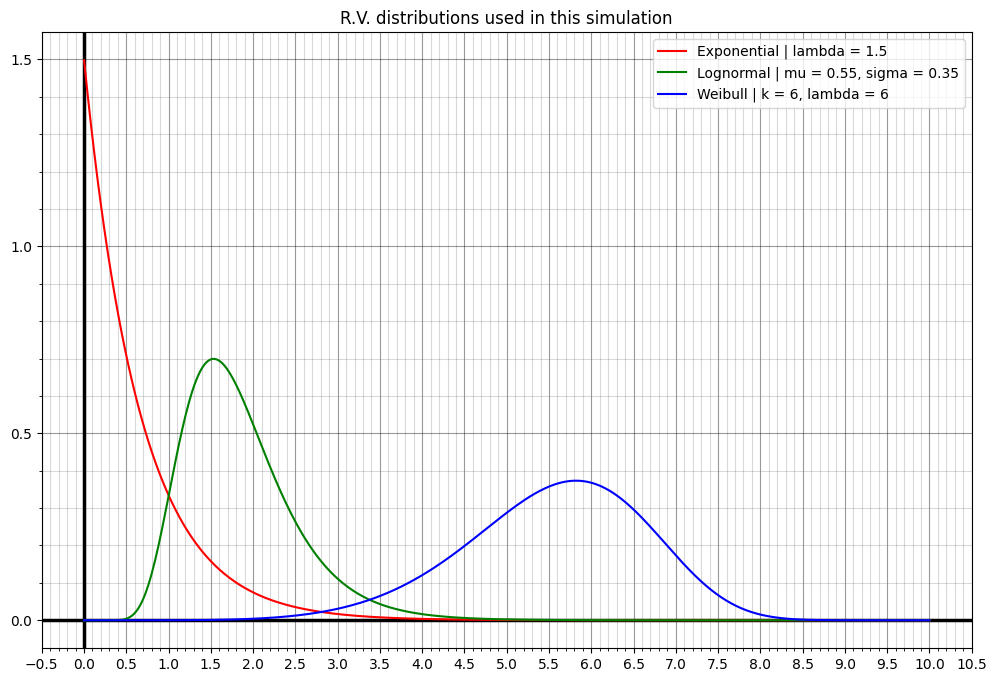

In [215]:
def expovar(x):
    if x < 0:
        return 0
    else:
        return LAMBDA_EXP * np.exp(-LAMBDA_EXP * x)
    
expovar = np.vectorize(expovar)

def lognormal(x):
    return (1/(x * SIGMA_LOGNORM * np.sqrt(2 * np.pi))) * np.exp(-(log(x) - MU_LOGNORM)**2 / (2 * SIGMA_LOGNORM**2))

lognormal = np.vectorize(lognormal)

def weibull(x):
    if x < 0:
        return 0
    else:
        return (SHAPE_WEIBULL / SCALE_WEIBULL) * (x / SCALE_WEIBULL)**(SHAPE_WEIBULL-1) * np.exp(-(x/SCALE_WEIBULL)**SHAPE_WEIBULL)

weibull = np.vectorize(weibull)

xs = np.linspace(0.001, 10, 500)
ys1 = expovar(xs)
ys2 = lognormal(xs)
ys3 = weibull(xs)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)
bigticks = np.arange(-1, 11, 0.5)
smallticks = np.arange(-1, 11, 0.1)
ax.set_xticks(bigticks)
ax.set_xticks(smallticks, minor=True)
ax.set_yticks(bigticks)
ax.set_yticks(smallticks, minor=True)
ax.grid(which="minor", alpha=0.3, c="gray")
ax.grid(which="major", alpha=0.4, c="black")

ax.axhline(c="black", linewidth=2.5)
ax.axvline(c="black", linewidth=2.5)

plt.plot(xs, ys1, c="red", label=f"Exponential | lambda = {LAMBDA_EXP}")
plt.plot(xs, ys2, c="green", label=f"Lognormal | mu = {MU_LOGNORM}, sigma = {SIGMA_LOGNORM}")
plt.plot(xs, ys3, c="blue", label=f"Weibull | k = {SHAPE_WEIBULL}, lambda = {SCALE_WEIBULL}")

plt.title("R.V. distributions used in this simulation")
plt.legend()
plt.show()

In [216]:
class Stats:
    def __init__(self):
        self.q_wait_times = []
        self.s_wait_times = []
        self.nr_impatient_leavers = 0

stats = Stats()


In [217]:
def customer(env, name, medicine, pharmacy):
    """A customer tries to buy a *medicine* from the *pharmacy*.
    
    
    If the medicine is sold out, the customer leaves the pharmacy immediately.
    Otherwise, if they reach the counter they are served for an amount of time and then leave.
    If they stay in the queue for too long, the customer will eventually leave."""

    print(f"{env.now:.2f}: {name} arrived at the pharmacy.")
    arrival_time = env.now

    with pharmacy.counters.request() as my_turn: # request counter resource
        patience = patience_rng.weibull(SHAPE_WEIBULL) * SCALE_WEIBULL
        result = yield my_turn | env.timeout(patience) | pharmacy.sold_out[medicine] # check if it's customer's turn or the medicine is sold out

        queue_wait_time = env.now - arrival_time

        if my_turn not in result: # the medicine is sold out, the customer leaves
            if pharmacy.sold_out[medicine] in result:
                print(f"{env.now:.2f}: {name} left because {medicine} is sold out. Queue wait time: {queue_wait_time:.2f} minutes.")
                pharmacy.num_renegers[medicine] += 1
                return
            else:
                print(f"{env.now:.2f}: {name} left after their patience ran out. Queue wait time: {queue_wait_time:.2f} minutes.")
                stats.nr_impatient_leavers += 1
                return

        pharmacy.med_stock[medicine] -= 1 # the customer buys the medicine
        counter_access_time = env.now
        print(f"{env.now:.2f}: {name} reserved 1 unit of {medicine} after reaching the counter. Queue waiting time: {queue_wait_time:.2f} minutes.")
        stats.q_wait_times.append(queue_wait_time)

        if pharmacy.med_stock[medicine] < 1:
            print(f"{env.now:.2f}: LAST unit of {medicine} reserved by {name}. No more can be reserved!")
            pharmacy.sold_out_timestamp[medicine] = env.now
            pharmacy.sold_out[medicine].succeed()
            pharmacy.med_stock[medicine] = 0

        yield env.timeout(arrival_rng.lognormal(MU_LOGNORM, SIGMA_LOGNORM)) 
        
        service_time = env.now - counter_access_time
        stats.s_wait_times.append(service_time)
        total_wait_time = queue_wait_time + service_time
        print(f"{env.now:.2f}: {name} received {medicine} and left. Queue wait time: {queue_wait_time:.2f} minutes. Service time: {service_time:.2f} minutes. Total time spent at pharmacy: {total_wait_time:.2f}.")

In [218]:
def generate_customers(env, pharmacy):
    """Generate new *customers* until simulation ends."""

    i = 1
    while True:
        yield env.timeout(arrival_rng.exponential(1/LAMBDA_EXP)) # random.expovariate(LAMBDA_EXP)

        medicine = choice_rng.choice(pharmacy.medicines)
        if pharmacy.med_stock[medicine] >= 1: # check if the medicine the customer wants is in stock before spawning a process
            env.process(customer(env, f"Customer#{i}", medicine, pharmacy))
            i += 1

In [219]:
class Pharmacy(NamedTuple):
    counters: simpy.Resource
    medicines: List[str]
    med_stock: Dict[str, int]
    sold_out: Dict[str, simpy.Event]
    num_renegers: Dict[str, int]
    sold_out_timestamp: Dict[str, Optional[float]]

In [220]:
random.seed(SEED)
np.random.seed(SEED)
env = simpy.Environment()
medicines = [f"Medicine#{i}" for i in range(1, NR_MED_TYPES+1)]
pharmacy = Pharmacy(
    counters = simpy.Resource(env, capacity=NR_COUNTERS),
    medicines = medicines,
    med_stock = {medicine: MED_STOCK for medicine in medicines},
    sold_out = {medicine: env.event() for medicine in medicines},
    sold_out_timestamp = {medicine: None for medicine in medicines},
    num_renegers = {medicine: 0 for medicine in  medicines}
)

env.process(generate_customers(env, pharmacy))

<Process(generate_customers) object at 0x2b0246a3530>

In [221]:
env.run(until=SIM_TIME)

0.65: Customer#1 arrived at the pharmacy.
0.65: Customer#1 reserved 1 unit of Medicine#3 after reaching the counter. Queue waiting time: 0.00 minutes.
1.86: Customer#2 arrived at the pharmacy.
1.86: Customer#2 reserved 1 unit of Medicine#3 after reaching the counter. Queue waiting time: 0.00 minutes.
2.05: Customer#3 arrived at the pharmacy.
2.05: Customer#3 reserved 1 unit of Medicine#3 after reaching the counter. Queue waiting time: 0.00 minutes.
2.16: Customer#4 arrived at the pharmacy.
2.40: Customer#1 received Medicine#3 and left. Queue wait time: 0.00 minutes. Service time: 1.75 minutes. Total time spent at pharmacy: 1.75.
2.40: Customer#4 reserved 1 unit of Medicine#3 after reaching the counter. Queue waiting time: 0.23 minutes.
3.14: Customer#3 received Medicine#3 and left. Queue wait time: 0.00 minutes. Service time: 1.09 minutes. Total time spent at pharmacy: 1.09.
4.31: Customer#4 received Medicine#3 and left. Queue wait time: 0.23 minutes. Service time: 1.91 minutes. Total 

In [222]:
for medicine in medicines:
    print(medicine)
    if pharmacy.sold_out[medicine].triggered:
        sellout_time = pharmacy.sold_out_timestamp[medicine]
        num_renegers = pharmacy.num_renegers[medicine]
        print(f"Sold out {sellout_time:.2f} minutes after pharmacy opened.")
        print(f"{num_renegers} people had to abandon the queue and leave the pharmacy.")
    else:
        print(f"Remaining stock: {pharmacy.med_stock[medicine]} / {MED_STOCK}")

    print("-----------------------------------------------------------------")

print(f"\n{stats.nr_impatient_leavers} people left the queue due to waiting too long.")

Medicine#1
Remaining stock: 1 / 25
-----------------------------------------------------------------
Medicine#2
Sold out 46.64 minutes after pharmacy opened.
0 people had to abandon the queue and leave the pharmacy.
-----------------------------------------------------------------
Medicine#3
Sold out 54.69 minutes after pharmacy opened.
0 people had to abandon the queue and leave the pharmacy.
-----------------------------------------------------------------

1 people left the queue due to waiting too long.


In [223]:
avg_q_time = sum(stats.q_wait_times) / len(stats.q_wait_times)
avg_s_time = sum(stats.s_wait_times) / len(stats.s_wait_times)

print(f"Average queue wait time: {avg_q_time:.2f} minutes")
print(f"Average service time: {avg_s_time:.2f} minutes")

max_q_time = max(stats.q_wait_times)
print(f"Maximum queue waiting time: {max_q_time:.2f} minutes")

Average queue wait time: 1.84 minutes
Average service time: 1.90 minutes
Maximum queue waiting time: 5.31 minutes


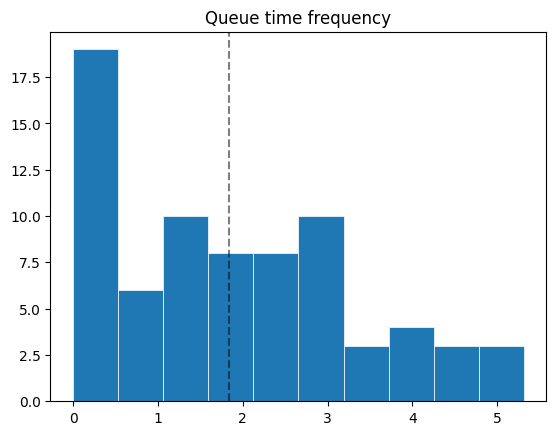

In [224]:
plt.hist(stats.q_wait_times, bins=10, linewidth=0.5, edgecolor="white")
plt.title("Queue time frequency")
plt.axvline(avg_q_time, alpha=0.5, c="black", ls="--")
plt.show()